# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [18]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
                             accuracy_score, precision_score, recall_score)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


In [19]:
def compute_metrics(prdct_y: np.array, obsrv_y: np.array, thr: float = 0.5):

    '''
        Takes a predicted y and then the observed y and computes a confusion matrix
        Returns the predicted y accuracy, precision, and recall
    '''
    thr = 0.5
    y_pred = (prdct_y >= thr).astype(int)

    acc = accuracy_score(obsrv_y, y_pred)
    prec = precision_score(obsrv_y, y_pred, zero_division=0)
    rec = recall_score(obsrv_y, y_pred, zero_division=0)

    print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}")

    fig = plt.figure()
    ConfusionMatrixDisplay.from_predictions(obsrv_y, y_pred)
    plt.title(f"Confusion Matrix (threshold={thr:.2f})")
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec}

## 1) Train/Test Split

In [20]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [21]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

Accuracy:  0.723
Precision: 0.733
Recall:    0.678


<Figure size 640x480 with 0 Axes>

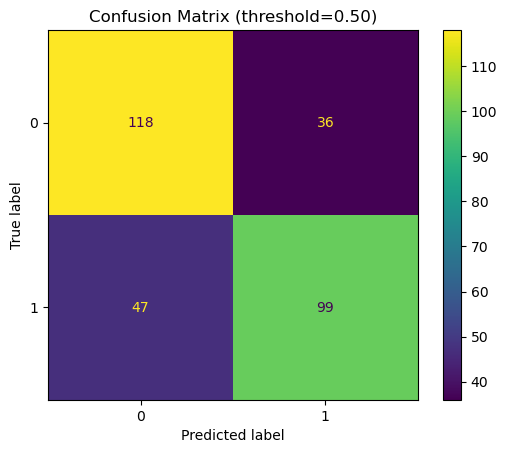

In [22]:
# full_set metrics

fullset_metrics = compute_metrics(yprob_full, yf_test)

Accuracy:  0.717
Precision: 0.736
Recall:    0.651


<Figure size 640x480 with 0 Axes>

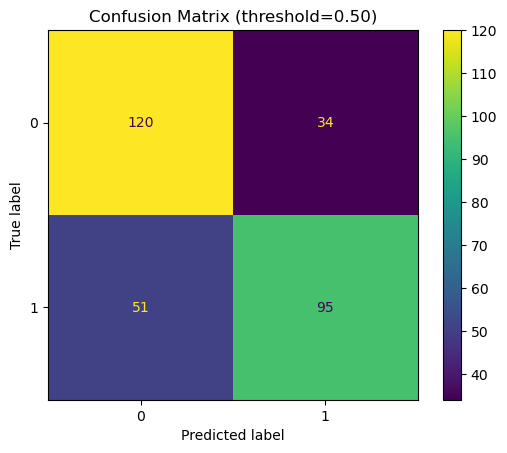

In [23]:
# reduced_set metrics

reduced_metrics = compute_metrics(yprob_reduced, yr_test)

## 4) Plot ROC and Precision–Recall Curves

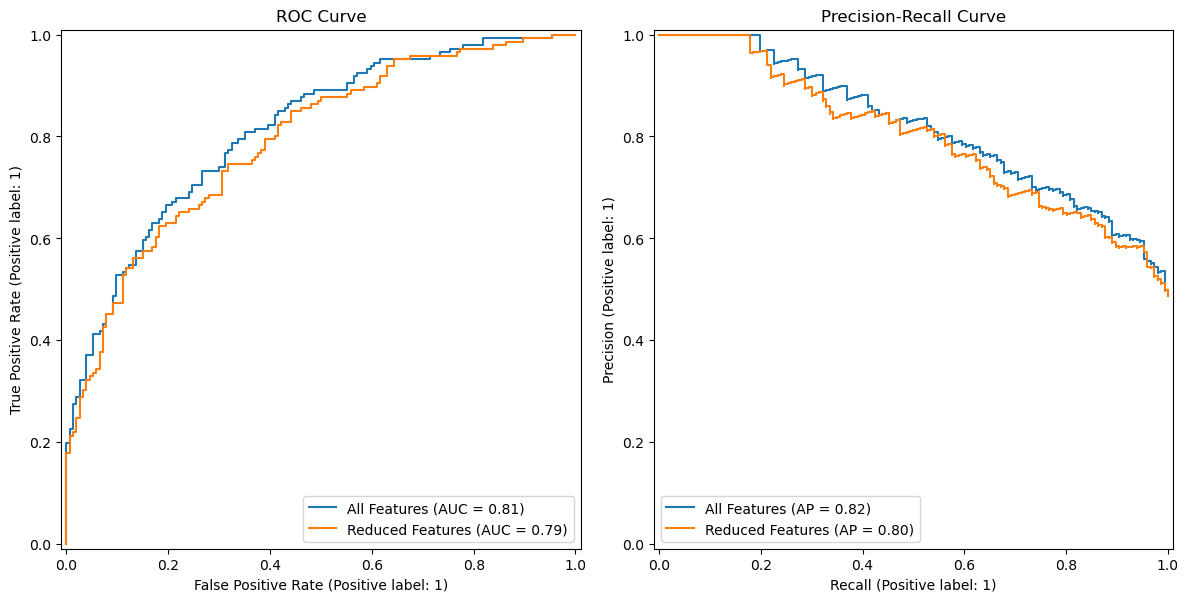

In [25]:
# TODO: Plot ROC and PR curves for both models on shared axes

fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (12,6))

RocCurveDisplay.from_predictions(yf_test, yprob_full, ax = ax[0], name = "All Features")
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, ax = ax[0], name = "Reduced Features")

PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, ax = ax[1], name = "All Features")
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, ax = ax[1], name = "Reduced Features")

ax[0].set_title("ROC Curve")
ax[1].set_title("Precision-Recall Curve")

fig.tight_layout()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1. The All-Features model has slightly higher scores but not by much. It implies that there is some independent information contained within the PWAT but that CAPE and PWAT are largely correlated, at least in the dataset provided. 
2. At a 0.5 Threshold, the Full Feature model has slightly better recall (0.678 vs 0.651). The Reduced feature model has marginally better precision though at just 0.003 difference, I don't know how statistically significant that is. 